*Data Challenge for MODE 2022 Workshop on Differentiable Programming, Crete
Copyright (C) 2022 Giles C Strong*

*This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, version 3 only of the License.*

*This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.*

*You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.*

# A Voting model to reconstruct walls from muon scattering data

This is the reference code to reproduce my solution for the Data Challenge for MODE 2022 Workshop on Differentiable Programming.

This is a list of all packages used in this notebook. Since not all of them are going to be installed in your environment, I recommend running this setup.

In [1]:
#!pip install h5py matplotlib numpy seaborn tqdm torch torchvision

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import h5py
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import math
from matplotlib.colors import LogNorm

## Data loading

*This section is taken from the reference notebook.*

If you haven't already downloaded the dataset, do so using, e.g. the uncommented command below. You only need to run this once.

In [4]:
#!mkdir data
#!wget -O data/train.h5 https://zenodo.org/record/6866891/files/train.h5
#!wget -O data/test.h5 https://zenodo.org/record/6866891/files/test.h5    

Point this to the directory where you have the data stored

In [5]:
DATA = Path('data')

Data files are in HDf5 format. The training file contains two datasets:
- `'x0'`: a set of voxelwise X0 predictions (float32)
- `'targs'`: a set of voxelwise classes (int):
    - 0 = soil
    - 1 = wall
    
The format of the datasets is a rank-4 array, with dimensions corresponding to (samples, z position, x position, y position).
All passive volumes are of the same size: 10x10x10 m, with cubic voxels of size 1x1x1 m, i.e. every passive volume contains 1000 voxels.
The arrays are ordered such that zeroth z layer is the bottom layer of the passive volume, and the ninth layer is the top layer.

Our job is to convert the X0 values into the target class values, for every voxel.

Since we want to evaluate the performance of our methods, we split off a portion of the training data to be used for validating performance, see e.g. https://www.fast.ai/2017/11/13/validation-sets/.

In [6]:
h5 = h5py.File(DATA/'train.h5', 'r')

Let's check the number of samples available:

In [7]:
h5['targs'].shape

(106129, 10, 10, 10)

So in total we have over 100,000 samples. We will use most of these for training and set a small set of 1024 samples aside for a test dataset.

In [8]:
n = 106129
n_train = n-1024

In [9]:
train_x = h5['x0'][:n_train]
train_y = h5['targs'][:n_train]
valid_x = h5['x0'][n_train:n]
valid_y = h5['targs'][n_train:n]

In [10]:
train_x.shape, valid_y.shape

((105105, 10, 10, 10), (1024, 10, 10, 10))

In [11]:
h5.close()

## Data viewing

Looking at raw 3D arrays of data is a bit uninformative, so in this section we'll plot it out.

Fist, we'll look at the targets from a top-down perspective, and plot them in x & y.

Below, we plot out 5 examples and flatten them along the z axis (`.any(0)`). The black sections are soil (class=0) and the white sections are the walls (class=1)

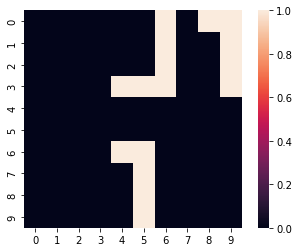

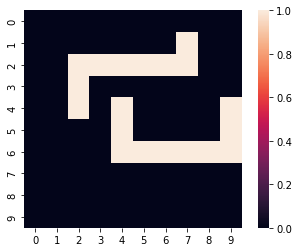

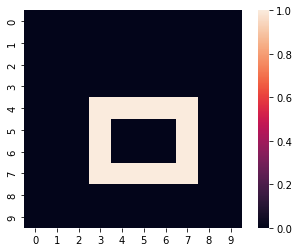

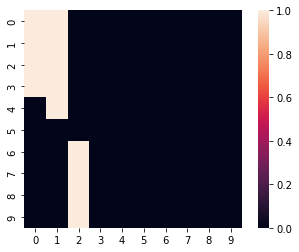

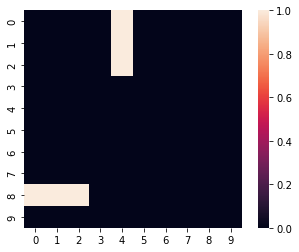

In [12]:
for targ in train_y[:5]:
    sns.heatmap(targ.any(0), square=True)
    plt.show()

In [13]:
def plot_x0_targ(x0:np.ndarray, targ:np.ndarray) -> None:
    n_layers = x0.shape[0]
    fig, axs = plt.subplots(n_layers,2, figsize=(8, 8*16/9))
    pred_cbar_ax = fig.add_axes([0.45, 0.25, 0.03, 0.5])
    true_cbar_ax = fig.add_axes([0.90, 0.25, 0.03, 0.5])

    for layer in range(n_layers-1,-1,-1):
        sns.heatmap(x0[layer], ax=axs[n_layers-layer-1,0], vmin=np.nanmin(x0), vmax=np.nanmax(x0), cbar=(layer==0), cbar_ax=pred_cbar_ax if layer == 0 else None, square=True, cmap='viridis')
        sns.heatmap(targ[layer], ax=axs[n_layers-layer-1,1], vmin=np.nanmin(targ), vmax=np.nanmax(targ), cbar=(layer==0), cbar_ax=true_cbar_ax if layer == 0 else None, square=True, cmap='viridis')
        axs[n_layers-layer-1][0].set_ylabel(f"Layer {layer}")
    axs[-1][0].set_xlabel("X0")
    axs[-1][1].set_xlabel("Target")
    plt.show()

Due to the large range of X0s the colour scale gets compressed. Instead we can plot on a log-scale to better see differences in the low X0 region

In [14]:
def plot_x0_targ_log(x0:np.ndarray, targ:np.ndarray) -> None:
    #targ=targ.astype("int")
    n_layers = x0.shape[0]
    fig, axs = plt.subplots(n_layers,2, figsize=(8, 8*16/9))
    pred_cbar_ax = fig.add_axes([0.45, 0.25, 0.03, 0.5])
    true_cbar_ax = fig.add_axes([0.90, 0.25, 0.03, 0.5])
    cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(np.nanmin(x0))), 1+math.ceil(math.log10(np.nanmax(x0))))]
    log_norm = LogNorm(vmin=np.nanmin(x0), vmax=np.nanmax(x0))
    
    for layer in range(n_layers-1,-1,-1):
        sns.heatmap(x0[layer], ax=axs[n_layers-layer-1,0], vmin=np.nanmin(x0), vmax=np.nanmax(x0), cbar=(layer==0), cbar_ax=pred_cbar_ax if layer == 0 else None, square=True, cmap='viridis', norm=log_norm, cbar_kws={"ticks": cbar_ticks})
        sns.heatmap(targ[layer], ax=axs[n_layers-layer-1,1], vmin=np.nanmin(targ), vmax=np.nanmax(targ), cbar=(layer==0), cbar_ax=true_cbar_ax if layer == 0 else None, square=True, cmap='viridis')
        axs[n_layers-layer-1][0].set_ylabel(f"Layer {layer}")
    axs[-1][0].set_xlabel("X0")
    axs[-1][1].set_xlabel("Target")
    plt.show()

## The Intersection over Unity

The intersection is the area of overlap between predicted walls and true wall, and the union is the summed area of predicted walls and true walls. By taking the ratio, we quantify the precision of our predictions: if we predicted a large area for one walls, then we would identify all the voxels with walls, however if there are only a few voxels that actually are walls, then the large union would reduce the IOU. This is computed separately for each sample, and then we compute the mean IOU across the samples.

The IOU is a float between 0 and 1, with 1 being a perfect prediction, in which only every voxel is correctly identified as either soil or wall.

In [15]:
def binary_iou(preds:np.ndarray, targs:np.ndarray, as_mean:bool=True, smooth:float=1e-17) -> float:
    r'''
    Assumes that preds and targs have a batch dimension, and no class dimension, i.e. (batch, z, x, y)
    If the batch dimesion is missing, e.g. your are computing the IOU for a single sample,
    add it with e.g. preds[None], targs[None]
    '''
    
    preds = preds.reshape(len(preds), 1, -1).astype(bool)
    targs = targs.reshape(len(targs), 1, -1).astype(bool)
    
    inter = (preds*targs).sum(-1)
    union = (preds+targs).sum(-1)
    iou = ((inter+smooth)/(union+smooth))  # Small epsilon in case of zero union

    if as_mean: iou = iou.mean() 
    return iou

## Setting up the models for training

The underlying idea is to take a bunch of relatively weak models and have them vote on individual voxels. A voxel is classified as a wall if a majority of these models agree that it is likely a wall.

In [16]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

Training can be sped up a lot by utilizing a GPU. Nvidia GPUs require the use of the CUDA version, while AMD GPUs require the ROCm based version. Depending on the specific AMD GPU, additional configurations may be necessary.

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


The data set will be enhanced by applying a set of rotations and mirror operations in order to gain additional samples.

In [18]:
#import os

import torchvision.transforms.functional as tft

class CustomImageDataset(Dataset,):
    def __init__(self, maps, labels, transform=None, target_transform=None, do_permutations=False):
        tempimg_labels = np.asarray(labels,dtype='float32')
        self.img_labels = torch.from_numpy(tempimg_labels)
        tempmaps = np.asarray(maps,dtype='float32')
        self.maps = torch.from_numpy(tempmaps)
        self.transform = transform
        self.target_transform = target_transform
        print(self.maps.shape)
        if do_permutations==True:
            self.__add_permutations__()
        print(self.maps.shape)

        
    def __add_permutations__(self):
        tmpim = torch.zeros((self.maps.shape[0]*4*2,10,10,10))
        tmplbl = torch.zeros((self.maps.shape[0]*4*2,10,10,10))
        for idx in range(self.maps.shape[0]):
            transform = range (0,8)
            for x in transform:
                image=self.maps[idx]
                mask=self.img_labels[idx]
                if x > 0 and x < 4:
                    image=tft.rotate(image,x*90.)
                    mask=tft.rotate(mask,x*90.)
                elif x < 6:
                    image = tft.hflip(image)
                    mask = tft.hflip(mask)
                else :
                    if x == 5 :
                        image=tft.rotate(self.maps[idx],90.)
                        mask=tft.rotate(self.img_labels[idx],90.)
                    image = tft.vflip(image)
                    mask = tft.vflip(mask)
                tmpim[idx*4*2+x] = image
                tmplbl[idx*4*2+x]=mask
        self.maps=tmpim
        self.img_labels=tmplbl


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.maps[idx]
        label = self.img_labels[idx]
        return image, label

training_data=CustomImageDataset(train_x,train_y,do_permutations=True)
test_data=CustomImageDataset(valid_x,valid_y)

torch.Size([105105, 10, 10, 10])
torch.Size([840840, 10, 10, 10])
torch.Size([1024, 10, 10, 10])
torch.Size([1024, 10, 10, 10])


In [19]:
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

learning_rate = 1e-3
set_batch_size = 512
#The data needs to be uploaded to the device.

train_dataloader = DataLoader(training_data, batch_size=set_batch_size, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

Define the 5 models in use. These were selected in experiments and were the best performing models.

In [20]:
from torch import nn
import random
class NeuralNetwork1(nn.Module):
    def __init__(self):
        super(NeuralNetwork1, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1000,1280),
            nn.Tanh(),
            nn.Linear(1280,1000),
            nn.ReLU(),
            nn.Unflatten(1,(10,10,10))
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        
        return logits

class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1000,1000),
            nn.Tanh(),
            nn.Linear(1000,1000),
            nn.ReLU(),
            nn.Unflatten(1,(10,10,10))
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        
        return logits

class NeuralNetwork3(nn.Module):
    def __init__(self):
        super(NeuralNetwork3, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Tanh(),
            nn.Linear(1000,1000),
            nn.ReLU(),
            nn.Linear(1000,1000),
            nn.ReLU(),
            nn.Unflatten(1,(10,10,10))
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        
        return logits
    
class NeuralNetwork4(nn.Module):
    def __init__(self):
        super(NeuralNetwork4, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1000,1100),
            nn.Tanh(),
            nn.Linear(1100,1000),
            nn.ReLU(),
            nn.Linear(1000,1000),
            nn.ReLU(),
            nn.Linear(1000,1000),
            nn.ReLU(),
            nn.Unflatten(1,(10,10,10))
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        
        return logits

class NeuralNetwork5(nn.Module):
    def __init__(self):
        super(NeuralNetwork5, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1000,1000),
            nn.Tanh(),
            nn.Linear(1000,1000),
            nn.ReLU(),
            nn.Linear(1000,1000),
            nn.Tanh(),
            nn.Linear(1000,1000),
            nn.ReLU(),
            nn.Unflatten(1,(10,10,10))
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        
        return logits

models=[]
models.append(NeuralNetwork1().to(device))
models.append(NeuralNetwork2().to(device))
models.append(NeuralNetwork3().to(device))
models.append(NeuralNetwork4().to(device))
models.append(NeuralNetwork5().to(device))


In [21]:
loss_fn=nn.MSELoss().to(device)

In [22]:

#from torch.autograd import Variable
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        #Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % (128*4) == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred>.35, y)#.item()#binary_iou(pred>.35, y).item()

    test_loss /= num_batches
    print(f"Test Error: \n Accuracy: {(100*0):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    


In [23]:
optimizers = []
for model in models:
    optimizers.append(torch.optim.Adam(model.parameters(), lr=learning_rate))

In [24]:
epochs = 200

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")#
    for i,model in enumerate(models): 
        print(f"Training model {i+1}")
        train_loop(train_dataloader, model, loss_fn, optimizers[i])
        test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Training model 1
loss: 0.065447  [    0/840840]
loss: 0.041031  [262144/840840]
loss: 0.034690  [524288/840840]
loss: 0.031855  [786432/840840]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.045247 

Training model 2
loss: 0.070994  [    0/840840]
loss: 0.042435  [262144/840840]
loss: 0.033987  [524288/840840]
loss: 0.032516  [786432/840840]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.050390 

Training model 3
loss: 0.067456  [    0/840840]
loss: 0.043472  [262144/840840]
loss: 0.038825  [524288/840840]
loss: 0.035774  [786432/840840]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.048554 

Training model 4
loss: 0.063750  [    0/840840]
loss: 0.048516  [262144/840840]
loss: 0.041858  [524288/840840]
loss: 0.038223  [786432/840840]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.051160 

Training model 5
loss: 0.064755  [    0/840840]
loss: 0.048735  [262144/840840]
loss: 0.042452  [524288/840840]
loss: 0.038862  [786432/840840]
Test Error: 
 Accuracy: 0.0%, Avg lo

loss: 0.027989  [262144/840840]
loss: 0.028289  [524288/840840]
loss: 0.027633  [786432/840840]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.039522 

Training model 2
loss: 0.027518  [    0/840840]
loss: 0.028254  [262144/840840]
loss: 0.027282  [524288/840840]
loss: 0.026620  [786432/840840]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.040362 

Training model 3
loss: 0.029808  [    0/840840]
loss: 0.028768  [262144/840840]
loss: 0.028125  [524288/840840]
loss: 0.029233  [786432/840840]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.039412 

Training model 4
loss: 0.022641  [    0/840840]
loss: 0.022730  [262144/840840]
loss: 0.021941  [524288/840840]
loss: 0.022699  [786432/840840]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.033898 

Training model 5
loss: 0.028492  [    0/840840]
loss: 0.028009  [262144/840840]
loss: 0.026480  [524288/840840]
loss: 0.027272  [786432/840840]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.039296 

Epoch 10
-------------------------------
Training model 1
loss: 0.026748 

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.038358 

Training model 2
loss: 0.026385  [    0/840840]
loss: 0.026603  [262144/840840]
loss: 0.026460  [524288/840840]
loss: 0.025380  [786432/840840]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.038395 

Training model 3
loss: 0.027722  [    0/840840]
loss: 0.027579  [262144/840840]
loss: 0.029380  [524288/840840]
loss: 0.028414  [786432/840840]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.037619 

Training model 4
loss: 0.019771  [    0/840840]
loss: 0.020993  [262144/840840]
loss: 0.020927  [524288/840840]
loss: 0.020050  [786432/840840]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.031561 

Training model 5
loss: 0.024307  [    0/840840]
loss: 0.023732  [262144/840840]
loss: 0.023628  [524288/840840]
loss: 0.024026  [786432/840840]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.035356 

Epoch 18
-------------------------------
Training model 1
loss: 0.025938  [    0/840840]
loss: 0.025926  [262144/840840]
loss: 0.027518  [524288/840840]
loss: 0.026775  

KeyboardInterrupt: 

In [25]:
with torch.no_grad():
    pred=[]
    for model in models:
        dataiter = iter(test_dataloader)
        X, y = dataiter.next()
        #m=nn.Unflatten()
        pred.append(model(X))

We can now visualize the result for a randomly chosen sample from the test dataset. This shows the output of the vote on the left and the ground truth on the right.

torch.Size([1024, 10, 10, 10])


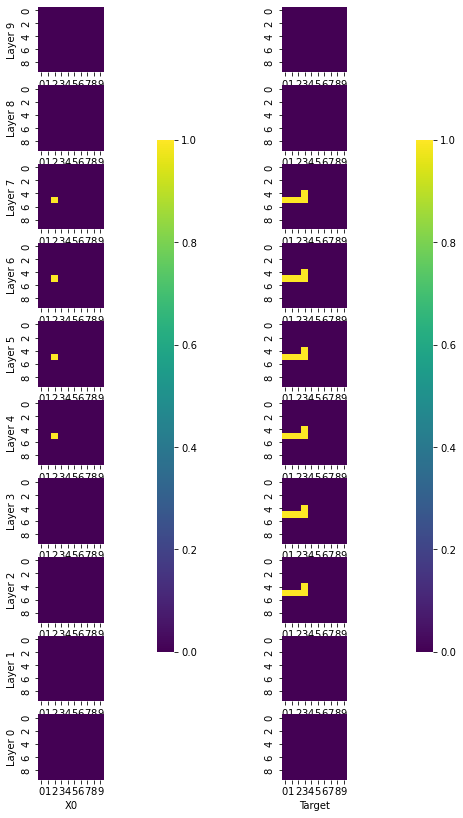

In [27]:
idx=74
print((pred[0].shape))
thr=0.35
vote=(pred[0]>thr).long()
for i in range(1,5):
    vote+=(pred[i]>thr).long()
plot_x0_targ((vote>2).detach().cpu().numpy()[idx], y.detach().cpu().numpy()[idx])

With this we can finally calculate the IOU for the whole model.

In [28]:
binary_iou((vote>2).long().detach().cpu().numpy(), y.detach().cpu().numpy())

0.04370796152042775

## Submission prep

The final step is to load the test dataset and perform the inference step to calculate the prediction

In [29]:
with h5py.File(DATA/'test.h5', 'r') as h5:
    test2_x = h5['x0'][()]
h5.close()

In [30]:
len(test2_x)


30036

We compute our predictions just like we did on the validation data

In [32]:
test_data2=CustomImageDataset(test2_x,test2_x)

test_dataloader2 = DataLoader(test_data2, batch_size=30036, shuffle=False, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

with torch.no_grad():
    pred=[]
    for model in models:
        dataiter = iter(test_dataloader2)
        X, y = dataiter.next()
        #m=nn.Unflatten()
        pred.append(model(X))
    
thr=0.35
vote=(pred[0]>thr).long()
for i in range(1,5):
    vote+=(pred[i]>thr).long()

vote= vote>2

torch.Size([30036, 10, 10, 10])
torch.Size([30036, 10, 10, 10])


To submit predictions, please save them to a HDF5 file using the function below. The file name should use the format `[your_full_name]_test_preds.h5`. Ypu can also include an option ID number in case you submit multiple times. Your final score, and score for the Friday announcements, will be computed on your submission with the highest ID number.

In [33]:
FULL_NAME_AND_ID = 'PHILIPP_MUNKES_ID0X'

In [34]:
with h5py.File(f'{FULL_NAME_AND_ID}_test_preds.h5', 'w') as h5:
    h5.create_dataset("preds", data=vote.cpu().detach().numpy().astype("int"), dtype="int", compression='lzf')